## Runtime Duration of UAT data
Analytics on Runtime data of the UAT reports.

In [163]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

# prep the environment
data_dir = Path.cwd() / "data"
data_file = data_dir / "uat_data.pkl"

%matplotlib inline


In [164]:
# load the UAT runtime data
if data_file.exists():
    uat_df = pd.read_pickle(data_file)
    print(f"Found {len(uat_df)} records.")
else:
    print(f"Processed data file missing ({data_file}), please run the Data Prep notebook first.")
    exit(-1)

# create time based DataFrame
time_df = uat_df.set_index('StartTime')


Found 1459 records.


### Overview


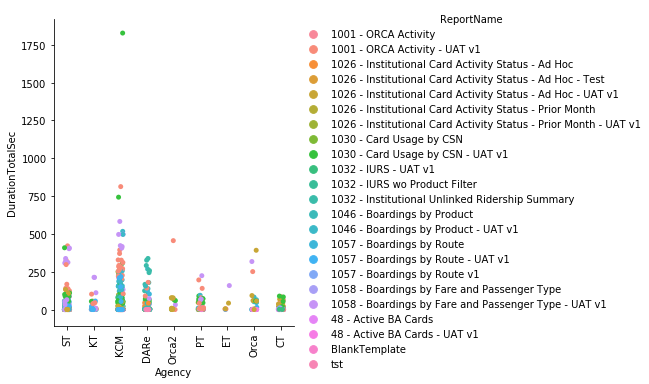

In [165]:
sns.catplot(x='Agency', y='DurationTotalSec', hue='ReportName', data=time_df)
plt.xticks(rotation=90)
plt.show()


### Runtime Split

What proportion of the total runtime is spent Retrieving, Rendering, and Processing the reports.


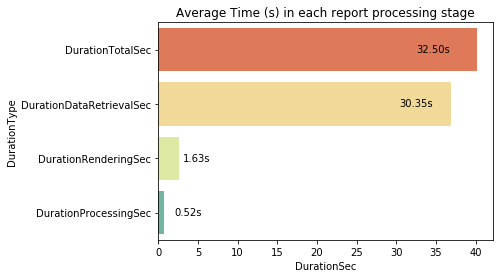

In [175]:
time_cols = ['DurationTotalSec', 'DurationDataRetrievalSec', 'DurationRenderingSec', 'DurationProcessingSec']
time_duration_tidy_df = time_df.melt(['User', 'ResultStatus', 'ReportName'], var_name='DurationType', value_name='DurationSec', value_vars=time_cols)
fig, ax = plt.subplots()    
sns.barplot(x='DurationSec', y='DurationType', data=time_duration_df, palette='Spectral', ci=None)
for i, tcol in enumerate(time_cols):
    val = time_duration_tidy_df[time_duration_tidy_df['DurationType'] == tcol]['DurationSec'].mean()
    if val > 5:
        offset = val - 0
    else:
        offset = val + 1.5
    ax.text(offset, i + 0.05, f"{val:.2f}s")
plt.title('Average Time (s) in each report processing stage')
plt.show()


### Interactivity

What proportion of the total runtime is spent on Interactive vs Scheduled report.
This will likely only change significantly once we have regular users.


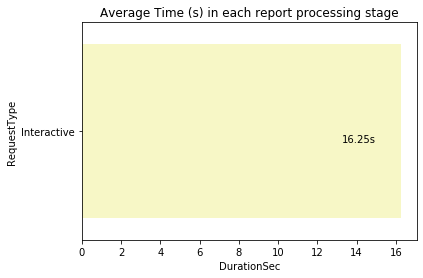

In [176]:
time_cols = ['DurationTotalSec', 'DurationDataRetrievalSec', 'DurationRenderingSec', 'DurationProcessingSec']
time_duration_df = time_df.melt(['RequestType', 'ReportName'], var_name='DurationType', value_name='DurationSec', value_vars=time_cols)
# fig, ax = plt.subplots()    
bplot = sns.barplot(x='DurationSec', y='RequestType', data=time_duration_df, palette='Spectral', ci=None)
for i, tcol in enumerate(time_duration_df['RequestType'].unique()):
    val = time_duration_df[time_duration_df['RequestType'] == tcol]['DurationSec'].mean()
    if val > 5:
        offset = val - 3
    else:
        offset = val + .5
    # ax.text(offset, i + 0.05, f"{val:.2f}s")
    bplot.text(offset, i + 0.05, f"{val:.2f}s")
plt.title('Average Time (s) in each report processing stage')
# bplot.text(0.5, 1, 'Average Time (s) in each report processing stage')
plt.show()

### Stats about runtime

In [178]:
display(uat_df['DurationTotalSec'].describe())

count    1459.000000
mean       32.504256
std        89.400420
min         0.000000
25%         0.082500
50%         1.289000
75%        23.589000
max      1827.589000
Name: DurationTotalSec, dtype: float64

Observation:
It's not until the 75th percentile that we get to the sample mean which makes me think that there are several outliers that are dragging the averages.

See the same stats, this time only the queries that had a successful result, and only those from actual UAT users:

In [179]:
live_df = uat_df[uat_df['ResultStatus'] == 'rsSuccess']
live_df = live_df[~live_df['User'].isin(['REPORTAD\\UATUserOrca','UATUserDARe'])]
display(live_df['DurationTotalSec'].describe())

count    1215.000000
mean       29.118109
std        76.140379
min         0.000000
25%         0.079500
50%         1.189000
75%        17.975000
max       812.567000
Name: DurationTotalSec, dtype: float64

As you can see, that skews the data more towards normal, although not totally.
And most reports ran in under 1.2s.

In [180]:
from scipy.stats import percentileofscore
num_seconds = 2.0
print(f"A {num_seconds:.1f}s runtime is the {percentileofscore(live_df['DurationTotalSec'], num_seconds):.1f}th percentile")

A 2.0s runtime is the 55.8th percentile


Here's a list of the reports that ran in the 90th percentile:

In [181]:
display(live_df[live_df['DurationTotalSec'] >= live_df['DurationTotalSec'].quantile(.90)])

,Server,ReportPath,User,ExecutionId,RequestType,Format,Parameters,ItemAction,StartTime,StopTime,...,DurationTotal,DurationTotalSec,DurationDataRetrievalSec,DurationProcessingSec,DurationRenderingSec,ReportGroup,ReportName,Agency,ParamNumInstitutions,ParamNumMonths
134,DEV-2-SSRS\MSSQLSERVER,/5-Kitsap Transit/1058 - Boardings by Fare and...,REPORTAD\UATUserKT,hw5kiw55iyy5jzi12tdmd1y0,Interactive,RPL,ServiceParticipantDimKey=142&SourceParticipant...,Render,2019-07-22 08:34:14.650,2019-07-22 08:37:47.717,...,213031,213.031,212.927,0.078,0.026,5-Kitsap Transit,1058 - Boardings by Fare and Passenger Type - ...,KT,0,1.0
433,DEV-2-SSRS\MSSQLSERVER,/4-King County Metro/1058 - Boardings by Fare ...,REPORTAD\UATUserKCM,bkbm0ye2p0y0eh55xgy5jz55,Interactive,RPL,ServiceParticipantDimKey=23&SourceParticipantD...,Render,2019-07-30 10:08:25.883,2019-07-30 10:11:54.860,...,208938,208.938,208.717,0.186,0.035,4-King County Metro,1058 - Boardings by Fare and Passenger Type - ...,KCM,0,0.0
457,DEV-2-SSRS\MSSQLSERVER,/4-King County Metro/1046 - Boardings by Produ...,REPORTAD\UATUserKCM,fkeutsnxus5ovz55c2w1l5j5,Interactive,RPL,ServiceParticipantDimKey=23&SourceParticipantD...,Render,2019-07-30 10:48:15.953,2019-07-30 10:51:05.813,...,169810,169.810,168.642,1.069,0.099,4-King County Metro,1046 - Boardings by Product - UAT v1,KCM,0,1.0
753,DEV-2-SSRS\MSSQLSERVER,/6-Pierce Transit/1026 - Institutional Card Ac...,REPORTAD\UATUserPT,k4xkmg45libfss55tj1a5k45,Interactive,RPL,AgencyDimKey=6&InstitutionDimKey=3724&BranchDi...,Render,2019-07-23 10:15:47.860,2019-07-23 10:17:04.337,...,76414,76.414,76.293,0.104,0.017,6-Pierce Transit,1026 - Institutional Card Activity Status - Ad...,PT,1,2.0
763,DEV-2-SSRS\MSSQLSERVER,/6-Pierce Transit/1030 - Card Usage by CSN - U...,REPORTAD\UATUserPT,ntja2zj2djpajc453rbffc55,Interactive,RPL,AgencyDimKey=7&InstitutionDimKey=18&FromDate=5...,Render,2019-07-23 10:30:47.580,2019-07-23 10:32:17.283,...,89663,89.663,89.594,0.042,0.027,6-Pierce Transit,1030 - Card Usage by CSN - UAT v1,PT,1,2.0
903,DEV-2-SSRS\MSSQLSERVER,/6-Pierce Transit/1046 - Boardings by Product ...,REPORTAD\UATUserPT,jay3ic55ief4bby5oqjh4445,Interactive,RPL,ServiceParticipantDimKey=155&SourceParticipant...,Render,2019-07-23 11:21:26.363,2019-07-23 11:23:00.617,...,94214,94.214,94.055,0.128,0.031,6-Pierce Transit,1046 - Boardings by Product - UAT v1,PT,0,1.0
960,DEV-2-SSRS\MSSQLSERVER,/6-Pierce Transit/1058 - Boardings by Fare and...,REPORTAD\UATUserPT,u3fpzw454gdf4avdegitbnyn,Interactive,RPL,ServiceParticipantDimKey=143&SourceParticipant...,Render,2019-07-23 13:46:25.890,2019-07-23 13:50:09.600,...,223669,223.669,223.586,0.060,0.023,6-Pierce Transit,1058 - Boardings by Fare and Passenger Type - ...,PT,0,1.0
1271,DEV-2-SSRS\MSSQLSERVER,/5-Kitsap Transit/1058 - Boardings by Fare and...,REPORTAD\UATUserKT,l23x4vyohcktwt55ebjsdoa2,Interactive,RPL,ServiceParticipantDimKey=142&SourceParticipant...,Render,2019-07-22 09:15:58.070,2019-07-22 09:19:30.433,...,212304,212.304,212.220,0.064,0.020,5-Kitsap Transit,1058 - Boardings by Fare and Passenger Type - ...,KT,0,1.0
1293,DEV-2-SSRS\MSSQLSERVER,/7-Sound Transit/1001 - ORCA Activity - UAT v1,REPORTAD\UATUserST,gmamaeey43y02e55hpneb555,Interactive,RPL,ServiceParticipantDimKey=155&FromDate=6%2F1%2F...,Render,2019-07-22 12:29:39.743,2019-07-22 12:32:00.420,...,140641,140.641,140.591,0.030,0.020,7-Sound Transit,1001 - ORCA Activity - UAT v1,ST,0,1.0
1295,DEV-2-SSRS\MSSQLSERVER,/7-Sound Transit/1001 - ORCA Activity - UAT v1,REPORTAD\UATUserST,gmamaeey43y02e55hpneb555,Interactive,RPL,ServiceParticipantDimKey=155&FromDate=6%2F1%2F...,Render,2019-07-22 12:32:01.360,2019-07-22 12:34:13.750,...,132364,132.364,132.331,0.017,0.016,7-Sound Transit,1001 - ORCA Activity - UAT v1,ST,0,1.0


#### Split of runtime duration frequency, by Agency

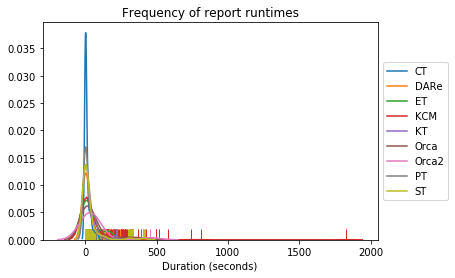

In [182]:
for agency, df in time_df.groupby('Agency'):
    sns.distplot(df['DurationTotalSec'], rug=True, hist=False, label=agency)
plt.xlabel("Duration (seconds)")
plt.title("Frequency of report runtimes")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


#### Number of months in the report vs the number of Institutions in the report

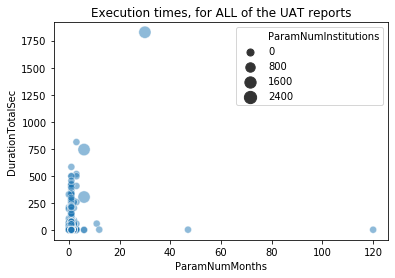

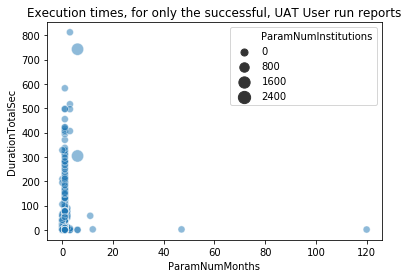

In [191]:
sp = sns.scatterplot(y='DurationTotalSec', x='ParamNumMonths', data=uat_df, alpha=0.5, size='ParamNumInstitutions', sizes=(50,150))
sp.set_title("Execution times, for ALL of the UAT reports")
plt.show()
sp = sns.scatterplot(y='DurationTotalSec', x='ParamNumMonths', data=live_df, alpha=0.5, size='ParamNumInstitutions', sizes=(50,150))
sp.set_title("Execution times, for only the successful, UAT User run reports")
plt.show()

### Some more serious Machine Learning stuff here
An K-Means clustering of runtimes to group them into different "similar" groups for more detailed analysis.

**Note**: due to a limitation of one of the graphs, any cluster containing only 1 point is removed.

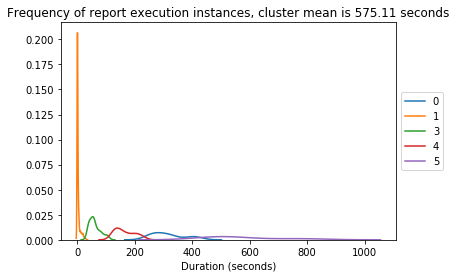

In [198]:
from sklearn.cluster import KMeans
import numpy as np
num_clusters = 6
kmeans = KMeans(n_clusters = num_clusters)
kmeans.fit(np.array(uat_df['DurationTotalSec']).reshape(-1,1))
uat_df['RunClass'] = kmeans.labels_

# print out the clusters
for runclass, df in uat_df.groupby('RunClass'):
    if len(df) < 2:
        continue
    sns.kdeplot(df['DurationTotalSec'], label=runclass)
    plt.xlabel("Duration (seconds)")
    df_mean = kmeans.cluster_centers_[runclass][0]
plt.title(f"Frequency of report execution instances, cluster mean is {df_mean:.2f} seconds")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()



,ClusterMean,Number
2,1827.589000,1
5,575.106000,8
0,315.755310,42
4,165.293097,62
3,60.922873,236
1,2.799621,1110


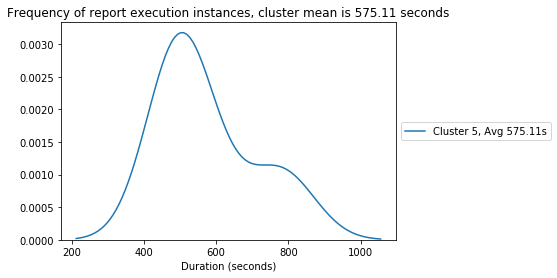

'There are 8 reports execution instances with the mean of 575.11 seconds'

,Agency,ReportPath,ExecutionId,RequestType,Format,Parameters,ItemAction,DurationTotalSec,DurationDataRetrievalSec,DurationProcessingSec,DurationRenderingSec,Source,ResultStatus,ByteCount,RowCount
1488,KCM,/1-ORCA/1058 - Boardings by Fare and Passenger...,tftlrprgyws0vjn42vpt2kuj,Interactive,RPL,ServiceParticipantDimKey=23&SourceParticipantD...,Render,582.390,581.924,0.440,0.026,Live,rsSuccess,45241,3466
1715,KCM,/4-King County Metro/1030 - Card Usage by CSN ...,vlkhto45zzz5t155c1byj1fu,Interactive,RPL,AgencyDimKey=5&InstitutionDimKey=17&Institutio...,Render,742.747,577.327,153.590,11.830,Live,rsSuccess,7559676,657343
3004,KCM,/1-ORCA/1046 - Boardings by Product - UAT v1,lp2qey55n23vio55bian2nfg,Interactive,RPL,ServiceParticipantDimKey=23&SourceParticipantD...,Render,516.740,515.039,1.592,0.109,Live,rsSuccess,45594,15425
3387,KCM,/1-ORCA/1058 - Boardings by Fare and Passenger...,kfxs4brr3sytik45i1a5u245,Interactive,RPL,ServiceParticipantDimKey=23&SourceParticipantD...,Render,497.986,496.350,0.877,0.759,Live,rsSuccess,45243,3466
3469,KCM,/1-ORCA/1001 - ORCA Activity - UAT v1,ktl1og45tj4v4j3kpf1fvi3n,Interactive,RPL,ServiceParticipantDimKey=23&FromDate=1%2F1%2F2...,Render,812.567,812.514,0.033,0.020,Live,rsSuccess,20522,263
3574,KCM,/1-ORCA/1046 - Boardings by Product - UAT v1,josbrcf1x4gouzzwexe5ni55,Interactive,RPL,ServiceParticipantDimKey=23&SourceParticipantD...,Render,496.520,494.874,1.483,0.163,Live,rsSuccess,45592,15425
6403,KCM,/4-King County Metro/1058 - Boardings by Fare ...,bpitd155s2oem5rf4aj1wkqc,Interactive,RPL,ServiceParticipantDimKey=23&SourceParticipantD...,Render,496.503,494.784,0.923,0.796,Live,rsSuccess,44697,3630
6816,Orca2,/4-King County Metro/1001 - ORCA Activity - UA...,anw5em45kvwakp55ndqfosvm,Interactive,RPL,ServiceParticipantDimKey=23&FromDate=6%2F1%2F2...,Render,455.395,455.344,0.033,0.018,Live,rsSuccess,20546,275


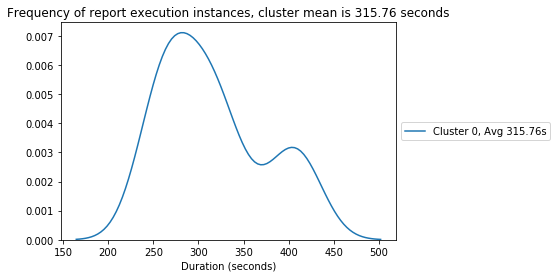

'There are 42 reports execution instances with the mean of 315.76 seconds'

,Agency,ReportPath,ExecutionId,RequestType,Format,Parameters,ItemAction,DurationTotalSec,DurationDataRetrievalSec,DurationProcessingSec,DurationRenderingSec,Source,ResultStatus,ByteCount,RowCount
1353,ST,/7-Sound Transit/1058 - Boardings by Fare and ...,yj1hjq55pdr0qiyfueof4kba,Interactive,RPL,ServiceParticipantDimKey=155&SourceParticipant...,Render,307.601,307.537,0.044,0.020,Live,rsSuccess,41505,419
1444,KCM,/1-ORCA/1001 - ORCA Activity - UAT v1,jbndb155rfcxwm55tr0x3s45,Interactive,RPL,ServiceParticipantDimKey=23&FromDate=6%2F1%2F2...,Render,370.229,370.196,0.017,0.016,Live,rsSuccess,20512,275
1494,KCM,/4-King County Metro/1001 - ORCA Activity - UA...,s1qjpi45joxhbvnvaaqkobmc,Interactive,RPL,ServiceParticipantDimKey=23&FromDate=6%2F1%2F2...,Render,393.547,393.498,0.031,0.018,Live,rsSuccess,20546,275
1618,Orca,/7-Sound Transit/1058 - Boardings by Fare and ...,wmigqg45bzk2auafwccgmm55,Interactive,RPL,ServiceParticipantDimKey=155&SourceParticipant...,Render,317.330,317.273,0.036,0.021,Live,rsSuccess,41507,419
1707,ST,/7-Sound Transit/1001 - ORCA Activity - UAT v1,ubk5i321mt3att45a4vu1r45,Interactive,RPL,ServiceParticipantDimKey=155&FromDate=6%2F1%2F...,Render,420.857,420.827,0.018,0.012,Live,rsSuccess,20470,281
1713,ST,/7-Sound Transit/1001 - ORCA Activity - UAT v1,legk1ieldxm3ujfhubgeyf55,Interactive,RPL,ServiceParticipantDimKey=155&FromDate=6%2F1%2F...,Render,325.552,325.493,0.026,0.033,Live,rsSuccess,20470,281
1782,KCM,/4-King County Metro/1030 - Card Usage by CSN ...,vlkhto45zzz5t155c1byj1fu,Interactive,CSV,AgencyDimKey=5&InstitutionDimKey=17&Institutio...,Render,304.034,0.000,0.073,303.961,Session,rsSuccess,89852761,0
1819,ST,/7-Sound Transit/1058 - Boardings by Fare and ...,0sgcpo55fomkiwntrwsogb55,Interactive,RPL,ServiceParticipantDimKey=155&SourceParticipant...,Render,311.473,311.432,0.024,0.017,Live,rsSuccess,41015,416
1917,ST,/7-Sound Transit/1058 - Boardings by Fare and ...,0sgcpo55fomkiwntrwsogb55,Interactive,RPL,ServiceParticipantDimKey=155&SourceParticipant...,Render,317.978,317.919,0.039,0.020,Live,rsSuccess,41505,419
2130,KCM,/4-King County Metro/1001 - ORCA Activity - UA...,5aalvd45gw5sie45git2m3qk,Interactive,RPL,ServiceParticipantDimKey=23&FromDate=6%2F1%2F2...,Render,291.530,291.507,0.023,0.000,Live,rsProcessingAborted,0,179


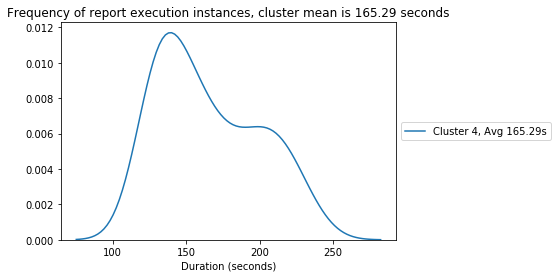

'There are 62 reports execution instances with the mean of 165.29 seconds'

,Agency,ReportPath,ExecutionId,RequestType,Format,Parameters,ItemAction,DurationTotalSec,DurationDataRetrievalSec,DurationProcessingSec,DurationRenderingSec,Source,ResultStatus,ByteCount,RowCount
134,KT,/5-Kitsap Transit/1058 - Boardings by Fare and...,hw5kiw55iyy5jzi12tdmd1y0,Interactive,RPL,ServiceParticipantDimKey=142&SourceParticipant...,Render,213.031,212.927,0.078,0.026,Live,rsSuccess,42652,983
433,KCM,/4-King County Metro/1058 - Boardings by Fare ...,bkbm0ye2p0y0eh55xgy5jz55,Interactive,RPL,ServiceParticipantDimKey=23&SourceParticipantD...,Render,208.938,208.717,0.186,0.035,Live,rsSuccess,44760,2249
457,KCM,/4-King County Metro/1046 - Boardings by Produ...,fkeutsnxus5ovz55c2w1l5j5,Interactive,RPL,ServiceParticipantDimKey=23&SourceParticipantD...,Render,169.810,168.642,1.069,0.099,Live,rsSuccess,44815,12393
673,ET,/3-Everett Transit/1058 - Boardings by Fare an...,luncjselmppgtruu1brbin55,Interactive,RPL,ServiceParticipantDimKey=13&SourceParticipantD...,Render,158.391,158.367,0.024,0.000,Live,rsProcessingAborted,0,358
960,PT,/6-Pierce Transit/1058 - Boardings by Fare and...,u3fpzw454gdf4avdegitbnyn,Interactive,RPL,ServiceParticipantDimKey=143&SourceParticipant...,Render,223.669,223.586,0.060,0.023,Live,rsSuccess,40119,651
1271,KT,/5-Kitsap Transit/1058 - Boardings by Fare and...,l23x4vyohcktwt55ebjsdoa2,Interactive,RPL,ServiceParticipantDimKey=142&SourceParticipant...,Render,212.304,212.220,0.064,0.020,Live,rsSuccess,42652,983
1293,ST,/7-Sound Transit/1001 - ORCA Activity - UAT v1,gmamaeey43y02e55hpneb555,Interactive,RPL,ServiceParticipantDimKey=155&FromDate=6%2F1%2F...,Render,140.641,140.591,0.030,0.020,Live,rsSuccess,20472,281
1295,ST,/7-Sound Transit/1001 - ORCA Activity - UAT v1,gmamaeey43y02e55hpneb555,Interactive,RPL,ServiceParticipantDimKey=155&FromDate=6%2F1%2F...,Render,132.364,132.331,0.017,0.016,Live,rsSuccess,20474,281
1338,ST,/7-Sound Transit/1001 - ORCA Activity - UAT v1,qjxfiwffx5v5qi554j1sjc45,Interactive,RPL,ServiceParticipantDimKey=155&FromDate=6%2F1%2F...,Render,123.435,123.404,0.019,0.012,Live,rsSuccess,20470,281
1429,PT,/6-Pierce Transit/1001 - ORCA Activity - UAT v1,anpwjsbjs41hrerlt1t5bm55,Interactive,RPL,ServiceParticipantDimKey=155&FromDate=6%2F1%2F...,Render,195.653,195.621,0.019,0.013,Live,rsSuccess,20472,281


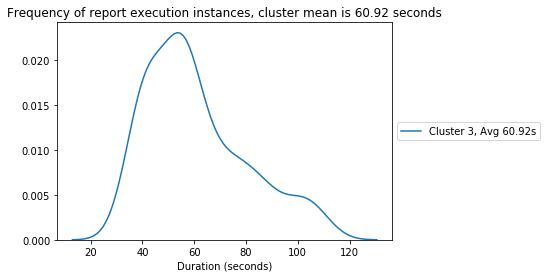

'There are 236 reports execution instances with the mean of 60.92 seconds'

,Agency,ReportPath,ExecutionId,RequestType,Format,Parameters,ItemAction,DurationTotalSec,DurationDataRetrievalSec,DurationProcessingSec,DurationRenderingSec,Source,ResultStatus,ByteCount,RowCount
131,KT,/5-Kitsap Transit/1058 - Boardings by Fare and...,ctojssuw3duq4tqwg1ilq4fo,Interactive,RPL,ServiceParticipantDimKey=142&SourceParticipant...,Render,111.089,111.056,0.033,0.000,Live,rsProcessingAborted,0,358
430,KCM,/4-King County Metro/1032 - IURS - UAT v1,ui12hf45zsj2kon0lwgtbr45,Interactive,RPL,LeadAgencyDimKey=5&InstitutionDimKey=17&Instit...,Render,73.567,73.321,0.103,0.143,Live,rsSuccess,50248,2443
683,KCM,/1-ORCA/1026 - Institutional Card Activity Sta...,xc23or2vlw5eyxrdp3a1sluv,Interactive,RPL,AgencyDimKey=5&InstitutionDimKey=17&BranchDimK...,Render,42.961,41.495,1.343,0.123,Live,rsSuccess,22457,15486
693,KCM,/1-ORCA/1030 - Card Usage by CSN - UAT v1,2ngizy2a4b50qs3weudnncvv,Interactive,RPL,AgencyDimKey=5&InstitutionDimKey=17&FromDate=6...,Render,48.464,46.241,1.093,1.130,Live,rsSuccess,7416643,12023
696,KCM,/1-ORCA/1030 - Card Usage by CSN - UAT v1,2ngizy2a4b50qs3weudnncvv,Interactive,RPL,AgencyDimKey=5&InstitutionDimKey=19&FromDate=6...,Render,55.459,54.619,0.350,0.490,Live,rsSuccess,3166057,6428
710,ET,/3-Everett Transit/1026 - Institutional Card A...,quh0eh45bmg30g55gxjveomm,Interactive,RPL,AgencyDimKey=4&InstitutionDimKey=1843&BranchDi...,Render,42.424,42.236,0.168,0.020,Live,rsSuccess,15915,7953
713,KCM,/1-ORCA/1030 - Card Usage by CSN - UAT v1,2ssas2qudy0mhbjldzpncqbr,Interactive,RPL,AgencyDimKey=5&InstitutionDimKey=17&FromDate=6...,Render,55.243,53.270,0.852,1.121,Live,rsSuccess,7416643,12023
720,KCM,/1-ORCA/1030 - Card Usage by CSN - UAT v1,zwztwcispkskmtbdsclqry3j,Interactive,RPL,AgencyDimKey=5&InstitutionDimKey=187&FromDate=...,Render,50.750,42.639,3.729,4.382,Live,rsSuccess,25324644,38153
753,PT,/6-Pierce Transit/1026 - Institutional Card Ac...,k4xkmg45libfss55tj1a5k45,Interactive,RPL,AgencyDimKey=6&InstitutionDimKey=3724&BranchDi...,Render,76.414,76.293,0.104,0.017,Live,rsSuccess,15929,5827
763,PT,/6-Pierce Transit/1030 - Card Usage by CSN - U...,ntja2zj2djpajc453rbffc55,Interactive,RPL,AgencyDimKey=7&InstitutionDimKey=18&FromDate=5...,Render,89.663,89.594,0.042,0.027,Live,rsSuccess,42882,2308


In [199]:
# for each cluster that's not the smallest cluster, and filtering out clusters that only have 1 entry
cluster_df = pd.DataFrame({'ClusterMean': kmeans.cluster_centers_[:,0], 'Number': pd.DataFrame(kmeans.labels_)[0].value_counts(sort=False)})
cluster_df.sort_values(by='ClusterMean', ascending=False, inplace=True)
display(cluster_df)

cluster_df.drop(cluster_df['ClusterMean'].idxmin(), inplace=True)
cluster_df = cluster_df[cluster_df['Number'] > 1]

for cluster in cluster_df.index:
    df = uat_df[uat_df['RunClass'] == cluster]
    df_mean = kmeans.cluster_centers_[cluster][0]
    sns.kdeplot(df['DurationTotalSec'], label=f"Cluster {cluster}, Avg {df_mean:.2f}s")
    plt.xlabel("Duration (seconds)")
    plt.title(f"Frequency of report execution instances, cluster mean is {df_mean:.2f} seconds")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    display(f"There are {len(df)} reports execution instances with the mean of {df_mean:.2f} seconds")
    display(df[['Agency', 'ReportPath', 'ExecutionId', 'RequestType', 'Format', 'Parameters', 'ItemAction', 
                'DurationTotalSec', 'DurationDataRetrievalSec', 'DurationProcessingSec', 'DurationRenderingSec',
                'Source', 'ResultStatus', 'ByteCount', 'RowCount']])